In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
SIZE_TRAIN=40
SIZE_VAL=30
SIZE_TEST=30
from sklearn.cluster import k_means,KMeans

In [2]:
def shuffle_dataset(x,y):
    """
    Shuffles two arrays in the same order.
    """
    randomize = np.arange(len(x))
    randomize=np.random.shuffle(randomize)
    return np.squeeze(x[randomize]),np.squeeze(y[randomize])
def read_data(file_name):
    df=pd.read_csv("data.txt",sep="  ",names=["X","y"],engine="python")
    X=df.X.values
    y=df.y.values
    return X[0:SIZE_TRAIN],y[0:SIZE_TRAIN],X[SIZE_TRAIN:SIZE_VAL+SIZE_TRAIN],y[SIZE_TRAIN:SIZE_VAL+SIZE_TRAIN],X[-SIZE_TEST:],y[-SIZE_TEST:]
def sigmoid_function( X ):
    return np.exp(-np.logaddexp(0, -X))
def calculate_Z(x,number_of_z,weights_W):            
    """
    Calculates values for hidden layers 
    Bias term should be added two instance before calling this function
    """   
    z=np.zeros(number_of_z,dtype=np.float64)

    for h in range(number_of_z):
        sum_of_wx=0
        for j in range(len(x)):
            sum_of_wx+=(weights_W[h][j]*x[j])
        z[h]=sigmoid_function(sum_of_wx)
    return z
def calculate_Y(z,weights_T):
    """
    Calculates values for output layers 
    Bias term should be added two instance before calling this function
    """
    sum_of_ih=0
    for h in range(len(z)):
         sum_of_ih+=weights_T[h]*z[h]
    return sum_of_ih

In [160]:

def predict_one_instance(x,w_values,m_values,s_values,k):  
    p_values=calculate_p_layer(x,m_values,s_values,k)
    p_values=np.insert(p_values,0,1)
    y=np.dot(w_values,p_values)
        
    return y

def predict(testX,w_values,m_values,s_values,k):
    """
    Predicts given dataset inputs.
    """
    return [predict_one_instance(x,w_values,m_values,s_values,k) for x in testX]
def loss_func(predictions,targets):
    """
    Computes binary cross entropy
    """
    #predictions = np.clip(predictions, epsilon, 1. - epsilon)
    total=0
    for y,r in zip(predictions,targets):
        total+=np.square(r-y)
    return total/2
def predict_rbf(X_train,k,m_values,s_values,w_values):
    predictions=[]
    for x in X_train:
        g=calculate_g(x,k,m_values,s_values)
        predictions.append(np.dot(w_values,g))
    return predictions

In [150]:

X_train,y_train,X_val,y_val,X_test,y_test=read_data("data.txt")

def initialize_m_s(X_train,y_train,k,epochs):
#     m_values=np.random.choice(X_train,k)
#     m_values=m_values.astype(np.float64)
#     learning_rate=0.02
#     error=100
#     prev_m=np.ones(k)
#     for m in range(epochs):     
#         shuffled_X,shuffled_Y=shuffle_dataset(X_train,y_train)

#         for x,r in zip(shuffled_X,shuffled_Y):
#             #calculate min distance to k_S
#             i=np.argmin(abs(m_values-x))
#             m_values[i]+=learning_rate*(x-m_values[i])
#         e=sum(m-prev_m)
#         if e<error:
#             error=e
#         if e<0.001:
#             break
#     clusters_index=np.array([],dtype=int)
#     #assign to clusters
#     for x,r in zip(X_train,y_train):
#         i=np.argmin(abs(m_values-x))
#         clusters_index=np.append(clusters_index,i)

    m_values,clusters_index,_=k_means(X_train.reshape(-1,1),k)
#    s_values=np.random.uniform(0.1,0.5,k)
    s_values=.0001*np.ones(k,np.float64)
    print("Centroids: ",m_values.flatten())
    print("Clusters_index: ",clusters_index)
    for i,c in enumerate(clusters_index):
        diff=abs(X_train[i]-m_values[c])
        if s_values[c]<diff:
            s_values[c]=diff
    
    return m_values.flatten(),s_values/2


In [151]:
def calculate_p(x,m,s):

    #a=np.exp(-2*np.log(x-m)-2*np.log(2*s))
    #a=np.exp(-np.power((x - m)/s, 2.)/2.)
    #print(str(x) +" " + str(m)+ " "+ str(s))
    a=np.exp(-np.square(x-m)/(2*np.square(s)))
    return a
def calculate_p_layer(x,m_values,s_values,k):
    p_values=np.zeros(k,dtype=np.float64)
    #print("x: " + str(x) + " s values: " + str(s_values)+" m values: "+ str(m_values))
    for m,s,i in zip(m_values,s_values,range(k)):
        p_values[i]=calculate_p(x,m,s)
    #print("P: ",p_values)
    return p_values
def loss_func(predictions,targets):
    """
    Computes binary cross entropy
    """
    #predictions = np.clip(predictions, epsilon, 1. - epsilon)
    total=0
    for y,r in zip(predictions,targets):
        total+=np.square(r-y)
    return total/2
def calculate_g(x,k,m_values,s_values):
    g_values=np.zeros(k)
    for m,s,i in zip(m_values,s_values,range(len(m_values))):
        g_values[i]=calculate_p(x,m,s)
    normalizer=sum(g_values)
    g_values=g_values/normalizer
    return g_values

In [152]:

def plot_m_s_g_w(m_values,s_values,w_values):
    linspace=np.linspace(-3,3,num=5000)
    
    fig=plt.figure(figsize=(30,10))

    #plt.scatter(X_train,np.ones(len(X_train))*-.008,alpha=0.8,marker='x')
    plt.scatter(m_values,np.zeros(k),s=450,label="Centroids",marker="D")

    normalizer=0
    for x in X_train:
        plt.scatter(x,0,s=200,c="red")
    for m,s in zip(m_values,s_values):
        p_h=calculate_p(linspace,m,s)
        normalizer+=p_h
        plt.scatter(linspace,p_h,alpha=0.5,s=0.5,label="P_h",c="green")
    for m,s in zip(m_values,s_values):
        plt.scatter(linspace,calculate_p(linspace,m,s)/normalizer,s=0.5,alpha=0.5,label="g_h",marker="*",c="navy")
    for w in w_values:
        plt.scatter(linspace,(calculate_p(linspace,m,s)/normalizer)*w,alpha=0.5,s=0.8,label="w_h",c="darkred")
#     lgnd=plt.legend( prop={'size': 20},fontsize=20,scatterpoints=1)
#     for handle in lgnd.legendHandles:
#         handle._sizes = [40]
        

    plt.show()
def predict_and_calc_loss(k,X_train,y_train,w_values,m_values,s_values):
    error=0
    for x,r in zip(X_train,y_train):
        g=calculate_g(x,k,m_values,s_values)
        y=np.dot(w_values,g)
        error+=np.square(r-y)
    return error/2

Centroids:  [ 0.10759621 -1.87359197  1.83580132  0.78693144 -1.03307363 -0.16265909
 -2.17664134 -1.3556435   1.9966238   1.3918033   0.57910881 -0.76487873
  1.02038764  1.640478    2.1735462 ]
Clusters_index:  [ 2  2  7  5  5  0  1 10  2  5 11  0  9  4  2  7  5 14 12  8 11 13 11  0
  6  6  1  8  1  2  6  6  5 12 10  3  5  6  4  3]
Epoch: 0, Training error: 9.288949603154604, Validation error: 5.047519105432301
Epoch: 1, Training error: 9.191777118220568, Validation error: 4.951153529917314
Epoch: 2, Training error: 9.104157628259639, Validation error: 4.862780713741646
Epoch: 3, Training error: 9.025403555844289, Validation error: 4.7816921207021394
Epoch: 4, Training error: 8.954882655379162, Validation error: 4.707246548397658
Epoch: 5, Training error: 8.892012981502479, Validation error: 4.638863287040125
Epoch: 6, Training error: 8.836258359299025, Validation error: 4.576016016200509
Epoch: 7, Training error: 8.78712430275511, Validation error: 4.518227355829982
Epoch: 8, Traini

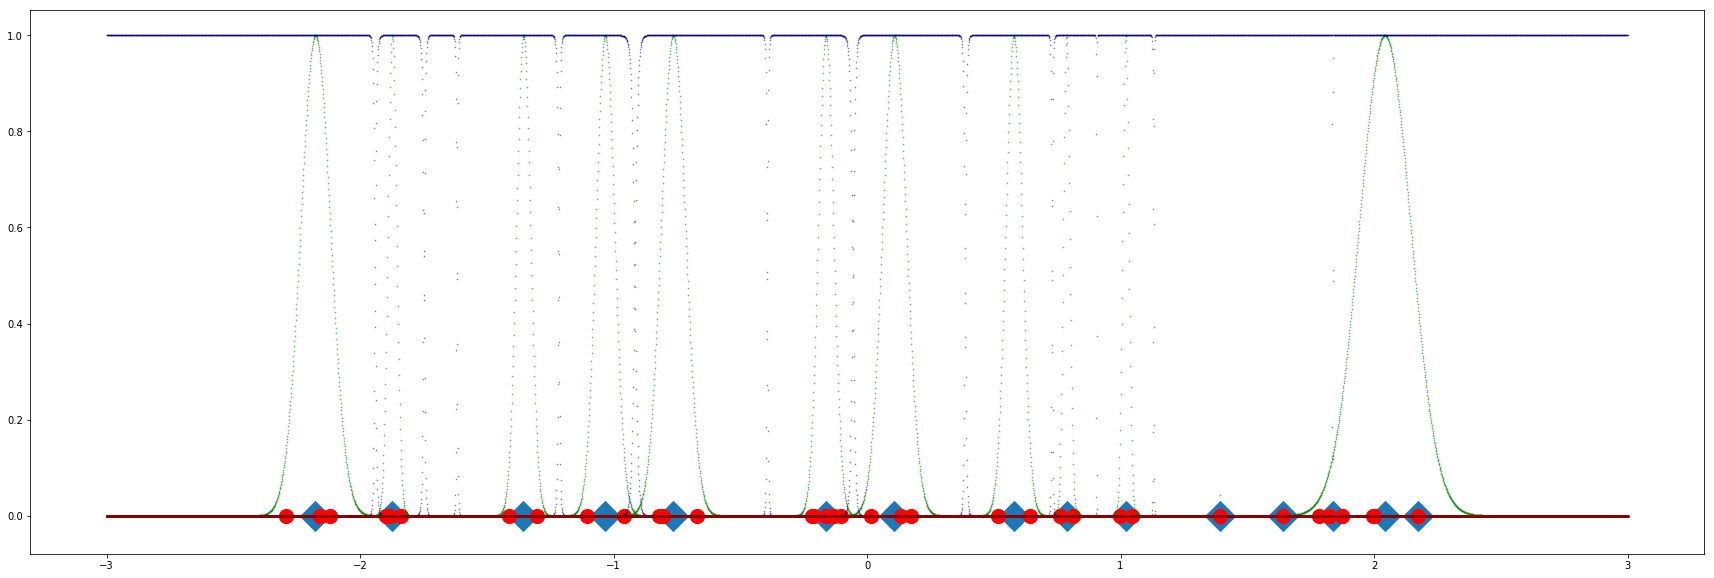

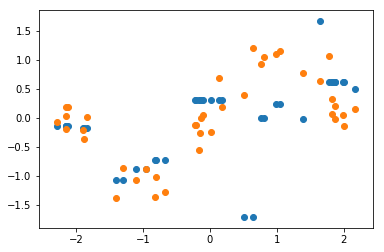

In [181]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
 
    return clusters, stds
np.random.seed(1000)
epochs=170
k=15
#m_values,s_values=kmeans(X_train,k)
m_values,s_values=initialize_m_s(X_train,y_train,k,1000)
w_values=np.random.uniform(-0.001,0.001,k)
#plot_m_s_g_w(m_values,s_values,w_values)  

plt.show()
learning_rate=0.01
for epoch in range(epochs):
    shuffled_X,shuffled_Y=shuffle_dataset(X_train,X_test)
    for x,r in zip(shuffled_X,shuffled_Y):
        g_values=calculate_g(x,k,m_values,s_values)
        y=np.dot(w_values,g_values)
        grad_w=learning_rate*(r-y)*g_values
        grad_m=(learning_rate*(r-y)*(w_values-y)*g_values*(x-m_values))/np.square(s_values)
        grad_s=(learning_rate*(r-y)*(w_values-y)*g_values*(np.square(x-m_values)))/np.power(s_values,3)
        w_values+=grad_w
        m_values+=grad_m
        s_values+=grad_s
    learning_rate*=0.995
    print("Epoch: {}, Training error: {}, Validation error: {}".format(epoch,predict_and_calc_loss(k,X_train,y_train,w_values,m_values,s_values),predict_and_calc_loss(k,X_val,y_val,w_values,m_values,s_values)))
print("Training error: {}, Validation error: {}".format(predict_and_calc_loss(k,X_train,y_train,w_values,m_values,s_values),predict_and_calc_loss(k,X_val,y_val,w_values,m_values,s_values)))

plot_m_s_g_w(m_values,s_values,w_values)  

plt.scatter(X_train,predict_rbf(X_train,k,m_values,s_values,w_values))
plt.scatter(X_train,y_train)
plt.show()

Centroids:  [-0.87215669  1.80324743 -2.17664134  0.68302012 -0.07257399 -1.3556435
  1.14419286 -1.87359197  2.05559793]
Clusters_index:  [1 1 5 4 4 4 7 3 1 4 0 4 6 0 1 5 4 8 6 8 0 1 0 4 2 2 7 8 7 1 2 2 4 6 3 3 4
 2 0 3]
[0.11696035 0.08138472 0.05687683 0.08413461 0.12336627 0.02751545
 0.12380522 0.01750928 0.05897413]


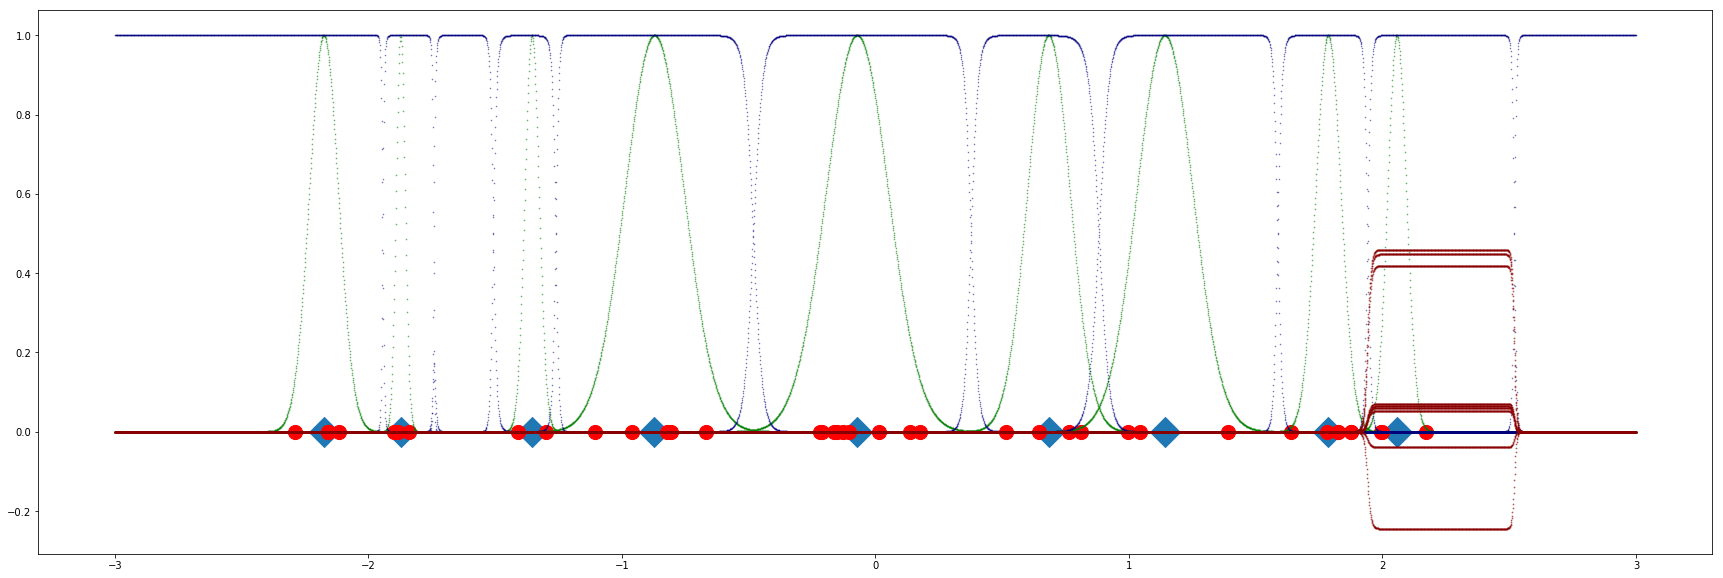

Training Error: 10.088643254567488
Validation Error: 18.4047293238174


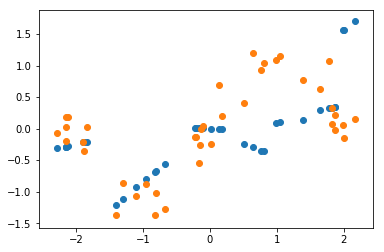

In [143]:
np.random.seed(1000)
epochs=20
k=9

def predict_moe(X_train,v_values,m_values,s_values,k):
    predictions=[]
    for x in X_train:
        g_values=calculate_g(x,k,m_values,s_values)
        #g_values=np.insert(g_values,0,1)
        w_values=v_values*x
        y=np.dot(w_values,g_values)
        predictions.append(y)
    return predictions
m_values,s_values=initialize_m_s(X_train,y_train,k,1400)
v_values=np.random.uniform(-0.001,0.001,k)
#plot_m_s_g_w(m_values,s_values,w_values)  
print(s_values)
momentum_rate=0.02
learning_rate=0.01
for epoch in range(epochs):
    shuffled_X,shuffled_Y=shuffle_dataset(X_train,X_test)
    prev_grad_v=np.zeros(k)
    prev_grad_m=np.zeros(k)
    prev_grad_s=np.zeros(k)
    for x,r in zip(shuffled_X,shuffled_Y):

        
        g_values=calculate_g(x,k,m_values,s_values)
        #g_values=np.insert(g_values,0,1)
        w_values=v_values*x
        y=np.dot(w_values,g_values)
        
        grad_v=learning_rate*(r-y)*g_values*x
        
        grad_m=np.zeros(k)
        grad_s=np.zeros(k)
        grad_m=(learning_rate*(r-y)*(w_values-y)*g_values*(x-m_values))/np.square(s_values)
        grad_s=(learning_rate*(r-y)*(w_values-y)*g_values*(np.square(x-m_values)))/np.power(s_values,3)
        
        
        
        #grad_m=(learning_rate*(r-y)*(w_values)*p_values*(x-m_values))/np.square(s_values)
        #grad_s=(learning_rate*(r-y)*(w_values)*p_values*(np.square(x-m_values)))/np.power(s_values,3)
   
        v_values+=(grad_v+prev_grad_v*momentum_rate)
        m_values+=(grad_m+prev_grad_m*momentum_rate)
        s_values+=(grad_s+prev_grad_s*momentum_rate)
        #if(np.any(grad_m<0.2)):
        prev_grad_m=np.copy(grad_m)
        prev_grad_v=np.copy(grad_v)
        
        prev_grad_s=np.copy(grad_s)
        
    learning_rate*=0.995
    #predictions=predict(X_train,w_values,m_values,s_values,k)
#     print("Epoch: "+str(epoch)+" Error: " + str(sum(np.square(predictions-y_train))/2))
plot_m_s_g_w(m_values,s_values,v_values)  
predictions=predict_moe(X_train,w_values,m_values,s_values,k)
print("Training Error: " + str(sum(np.square(predictions-y_train))/2))
print("Validation Error: " + str(sum(np.square(predict_moe(X_val,w_values,m_values,s_values,k)-y_val))/2))

plt.scatter(X_train,predictions)
plt.scatter(X_train,y_train)
plt.show()


Centroids:  [ 1.88736427 -2.06299783  0.68302012 -0.07257399 -1.3556435  -0.87215669
  1.14419286]
Clusters_index:  [0 0 4 3 3 3 1 2 0 3 5 3 6 5 0 4 3 0 6 0 5 0 5 3 1 1 1 0 1 0 1 1 3 6 2 2 3
 1 5 2]
[0.14309097 0.11369859 0.08413461 0.12336627 0.02751545 0.11696035
 0.12380522]


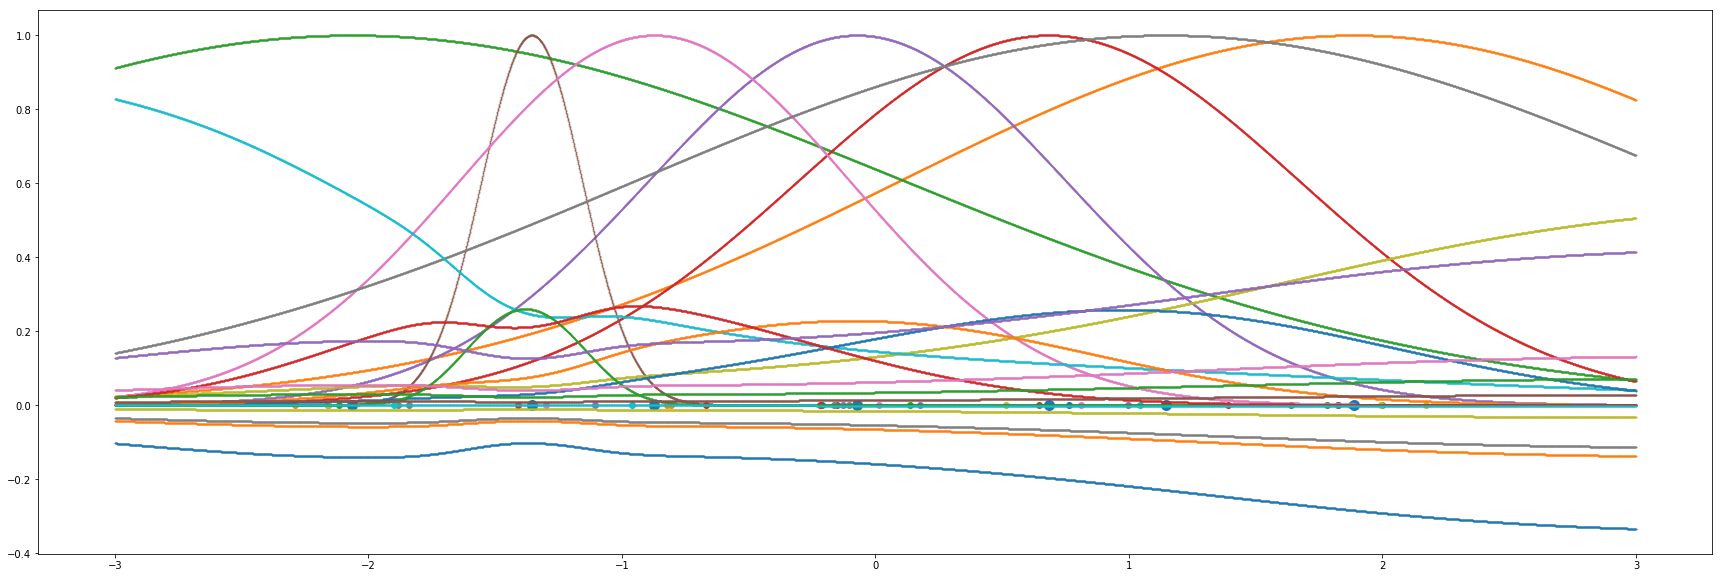

Training Error: 4.602403675348608


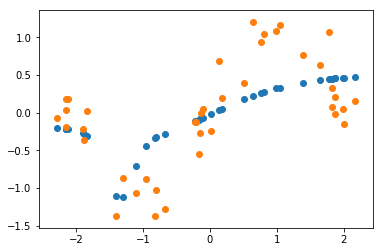

In [9]:
np.random.seed(1000)
epochs=40
k=7


m_values,s_values=initialize_m_s(X_train,y_train,k,1400)
w_values=np.random.uniform(-0.001,0.001,k+1)
#plot_m_s_g_w(m_values,s_values,w_values)  
print(s_values)
momentum_rate=0.9
learning_rate=0.01
for epoch in range(epochs):
    shuffled_X,shuffled_Y=shuffle_dataset(X_train,X_test)
    prev_grad_w=np.zeros(k+1)
    prev_grad_m=np.zeros(k)
    prev_grad_s=np.zeros(k)
    for x,r in zip(shuffled_X,shuffled_Y):

        p_values=calculate_p_layer(x,m_values,s_values,k)
        p_values=np.insert(p_values,0,1)
        y=np.dot(w_values,p_values)
        
        grad_w=learning_rate*(r-y)*p_values
        
        grad_m=np.zeros(k)
        grad_s=np.zeros(k)
        for m,s,i,w in zip(m_values,s_values,range(k),w_values):
            grad_m[i]=(learning_rate*(r-y)*w*p_values[i]*(x-m))/np.square(s)
            grad_s[i]=(learning_rate*(r-y)*w*p_values[i]*(np.square(x-m)))/np.power(s,3)       
        
        
        
        #grad_m=(learning_rate*(r-y)*(w_values)*p_values*(x-m_values))/np.square(s_values)
        #grad_s=(learning_rate*(r-y)*(w_values)*p_values*(np.square(x-m_values)))/np.power(s_values,3)
        if(np.any(grad_m)>0.1):
            grad_m=prev_grad_m
        w_values+=(grad_w+prev_grad_w*momentum_rate)
        m_values+=(grad_m+prev_grad_m*momentum_rate)
        s_values+=(grad_s+prev_grad_s*momentum_rate)
        #if(np.any(grad_m<0.2)):
        prev_grad_m=np.copy(grad_m)
        prev_grad_w=np.copy(grad_w)
        
        prev_grad_s=np.copy(grad_s)
        
    learning_rate*=0.99
    predictions=predict(X_train,w_values,m_values,s_values,k)
#     print("Epoch: "+str(epoch)+" Error: " + str(sum(np.square(predictions-y_train))/2))
plot_m_s_g_w(m_values,s_values,w_values)  
predictions=predict(X_train,w_values,m_values,s_values,k)
print("Training Error: " + str(sum(np.square(predictions-y_train))/2))
plt.scatter(X_train,predictions)
plt.scatter(X_train,y_train)
plt.show()
